In [1]:
#this notebook lays out tools for different sorts of non-interactive FLIM analyses
#we start with reading the picoquant files and calculating the g and s images
#then we select image points and record those decay profiles and phasor points
#next we show the smoothed thresholded phasor plot
#and calculate average decay profiles for points on that plot
#finally we unmix the image in 3 ways
#first we can unmix every pixel independently
#second we can umix the phasor bins and map that back to the image
#finally we can geometrically unmix the phasor

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
#import napari
import matplotlib.patches as patches
import matplotlib.colors as colors
import tifffile
import sys
sys.path.append('..')
import flimtools

In [4]:
#test it out on a sample image
#img=flimtools.readBin('TileScan_003_s1_z1_seq1.bin')
img=tifffile.imread('TileScan_003_s1_z1_seq1_crop_8bit.tif')

In [5]:
gimg,simg,sumimg=flimtools.calcGSimg(img,40.0,1.0)

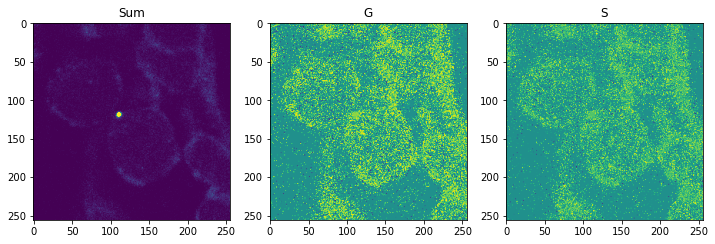

In [6]:
plt.figure(figsize=(12,6))
ax=plt.subplot(1,3,1)
ax.imshow(sumimg,vmax=sumimg.max()/4.0)
plt.title("Sum")
ax=plt.subplot(1,3,2)
ax.imshow(gimg,vmin=-1.0,vmax=1.0)
plt.title('G')
ax=plt.subplot(1,3,3)
ax.imshow(simg,vmin=-1.0,vmax=1.0)
plt.title('S')
plt.show()

In [8]:
#get the profile for a few different image regions
maxidx=sumimg.argmax()
maxx=maxidx%sumimg.shape[1]
maxy=int(maxidx/sumimg.shape[1])
print([maxidx,maxx,maxy])
maxidx2=sumimg[:100,:].argmax()
maxx2=maxidx2%sumimg.shape[1]
maxy2=int(maxidx2/sumimg.shape[1])
print([maxidx2,maxx2,maxy2])
maxidx3=sumimg[150:,:].argmax()
maxx3=maxidx3%sumimg.shape[1]
maxy3=int(maxidx3/sumimg.shape[1])+150
print([maxidx3,maxx3,maxy3])

[30319, 111, 118]
[24225, 161, 94]
[19176, 232, 224]


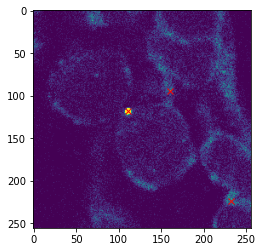

In [9]:
plt.imshow(sumimg,vmax=sumimg.max()/10.0)
plt.plot([maxx,maxx2,maxx3],[maxy,maxy2,maxy3],'rx')
plt.show()

In [10]:
profiles=[flimtools.measureCirc(img,maxx,maxy,5,np.sum),
          flimtools.measureCirc(img,maxx2,maxy2,5,np.sum),
          flimtools.measureCirc(img,maxx3,maxy3,5,np.sum)]

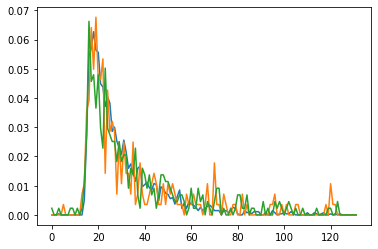

In [11]:
for i in range(3):
    plt.plot(profiles[i]/profiles[i].sum())

plt.show()

In [12]:
ptgs=np.array([flimtools.calcGS(profiles[i],40.0,1.0) for i in range(3)])

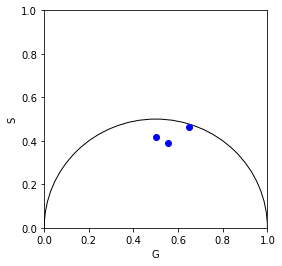

In [13]:
plt.figure(figsize=(4,4))
plt.plot(ptgs[:,0],ptgs[:,1],'bo')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('G')
plt.ylabel('S')
plt.gca().add_patch(patches.Arc((0.5,0.0),1.0,1.0,theta1=0.0,theta2=180.0))
plt.show()

In [14]:
#now try gating a region of the GS histogram
#first build the histogram
gshist,gbins,sbins,gthresh,sthresh,xthreshcoords,ythreshcoords=flimtools.getGSHist(gimg,simg,sumimg,3.0,3.0)

<IPython.core.display.Javascript object>


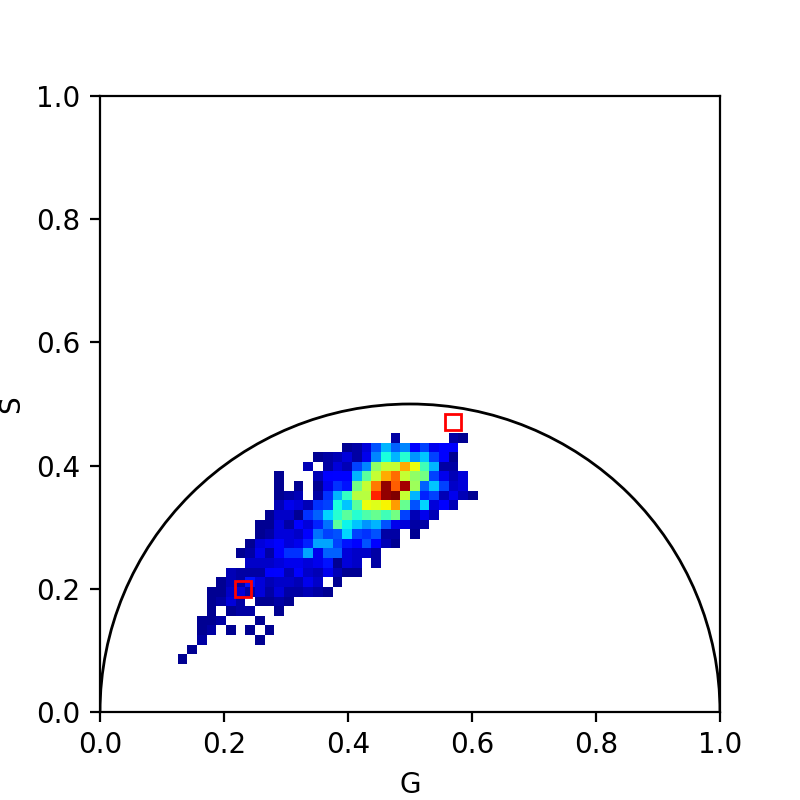

In [15]:
#need this magic to get interactivity
%matplotlib notebook
#plot the histogram
fig=plt.figure(figsize=(4,4))
plt.gca().pcolormesh(gbins,sbins,gshist.T,cmap=flimtools.getNiceCmap())
plt.gca().add_patch(patches.Arc((0.5,0.0),1.0,1.0,theta1=0.0,theta2=180.0))
plt.plot([0.23,0.57],[0.2,0.47],'rs',mfc='none')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('G')
plt.ylabel('S')
plt.show()
#cid=fig.canvas.mpl_connect('button_press_event',onclick)

In [16]:
mask1=flimtools.getRectHistMask([0.57,0.47,0.08,0.08],sumimg,gthresh,sthresh,xthreshcoords,ythreshcoords)
mask2=flimtools.getRectHistMask([0.23,0.2,0.1,0.1],sumimg,gthresh,sthresh,xthreshcoords,ythreshcoords)

[0.5299999999999999, 0.6099999999999999, 0.43, 0.51]
[0.18, 0.28, 0.15000000000000002, 0.25]


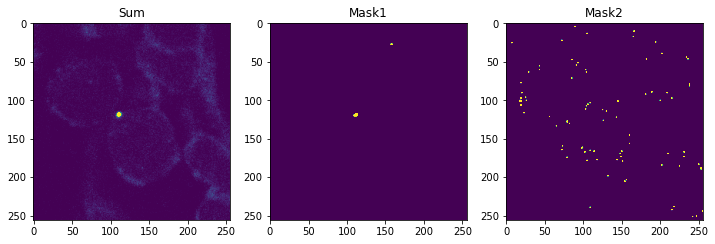

In [17]:
%matplotlib inline
plt.figure(figsize=(12,6))
ax=plt.subplot(1,3,1)
ax.imshow(sumimg,vmax=sumimg.max()/4.0)
plt.title("Sum")
ax=plt.subplot(1,3,2)
ax.imshow(mask1,vmax=0.1)
plt.title('Mask1')
ax=plt.subplot(1,3,3)
ax.imshow(mask2,vmax=0.1)
plt.title('Mask2')
plt.show()

In [18]:
hprofile1=img[:,mask1].sum(axis=1)
hprofile2=img[:,mask2].sum(axis=1)

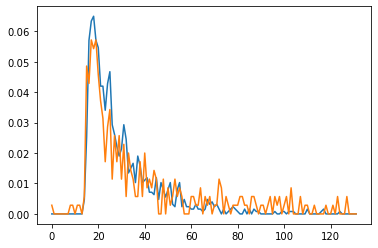

In [19]:
#plot the mask profile
plt.plot(hprofile1/hprofile1.sum())
plt.plot(hprofile2/hprofile2.sum())
plt.show()

In [20]:
#normalize our decays (or "spectra") for unmixing later
normspectra=np.array([hprofile1/hprofile1.sum(),hprofile2/hprofile2.sum()])

Fit coefficients:
[31786.15075767 17708.89528694]


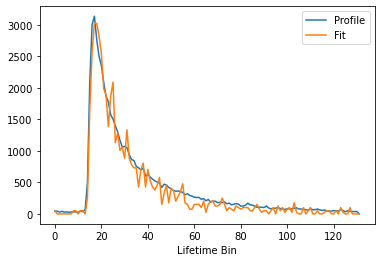

In [21]:
#test fitting the overall image profile
tprofile=img.sum(axis=2).sum(axis=1)
tcoef=flimtools.unmixDecays(np.array([tprofile]),normspectra)[0]
print('Fit coefficients:')
print(tcoef)
plt.plot(tprofile)
plt.plot(np.matmul(normspectra.T,tcoef))
plt.xlabel('Lifetime Bin')
plt.legend(['Profile','Fit'])
plt.show()

In [22]:
#unmix the whole stack with our profiles
unmixed=flimtools.unmixStack(img,normspectra)

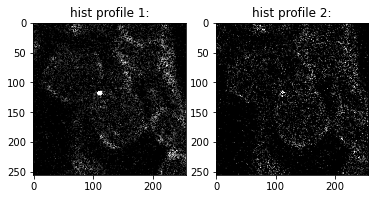

In [23]:
ax=plt.subplot(1,2,1)
ax.imshow(unmixed[0],vmin=0,vmax=unmixed[0].max()/20,cmap='gray')
plt.title('hist profile 1:')
ax=plt.subplot(1,2,2)
ax.imshow(unmixed[1],vmin=0,vmax=unmixed[0].max()/20,cmap='gray')
plt.title('hist profile 2:')
plt.show()

In [24]:
#now try unmixing the histogram bins and show that result
histunmixed,histfrac,histdecays=flimtools.unmixHist(img,normspectra,gthresh,sthresh,xthreshcoords,ythreshcoords)

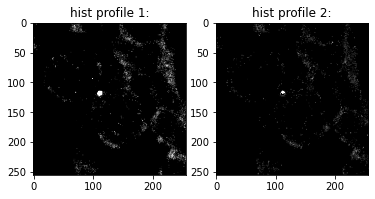

In [25]:
ax=plt.subplot(1,2,1)
ax.imshow(histunmixed[0],vmin=0,vmax=histunmixed[0].max()/20,cmap='gray')
plt.title('hist profile 1:')
ax=plt.subplot(1,2,2)
ax.imshow(histunmixed[1],vmin=0,vmax=histunmixed[0].max()/20,cmap='gray')
plt.title('hist profile 2:')
plt.show()

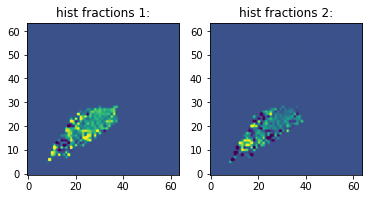

In [26]:
#show the fractions of the two components from our histogram
ax=plt.subplot(1,2,1)
ax.imshow(histfrac[0],vmin=-0.5,vmax=1.5)
ax.invert_yaxis()
plt.title('hist fractions 1:')
ax=plt.subplot(1,2,2)
ax.imshow(histfrac[1],vmin=-0.5,vmax=1.5)
ax.invert_yaxis()
plt.title('hist fractions 2:')
plt.show()

In [27]:
#now let's use our G and S positions from above to geometrically ummix
refpos=np.array([[0.57,0.47],[0.23,0.22]])
ungeom,fracgeom=flimtools.unmixGeom(refpos,sumimg,gthresh,sthresh,xthreshcoords,ythreshcoords)

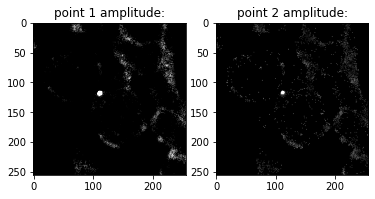

In [28]:
ax=plt.subplot(1,2,1)
ax.imshow(ungeom[0],vmin=0,vmax=ungeom[0].max()/20.0,cmap='gray')
plt.title('point 1 amplitude:')
ax=plt.subplot(1,2,2)
ax.imshow(ungeom[1],vmin=0,vmax=ungeom[0].max()/20.0,cmap='gray')
plt.title('point 2 amplitude:')
plt.show()

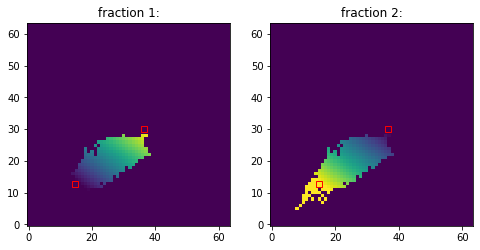

In [29]:
#show the fraction histogram images with the points overlayed
plt.figure(figsize=(8,4))
ax=plt.subplot(1,2,1)
ax.imshow(fracgeom[0],vmin=0,vmax=1)
ax.plot([0.23*64,0.57*64],[0.2*64,0.47*64],'rs',mfc='none')
ax.invert_yaxis()
plt.title('fraction 1:')
ax=plt.subplot(1,2,2)
ax.imshow(fracgeom[1],vmin=0,vmax=1)
ax.plot([0.23*64,0.57*64],[0.2*64,0.47*64],'rs',mfc='none')
ax.invert_yaxis()
plt.title('fraction 2:')
plt.show()

In [30]:
#try unmixing three components
refpos2=np.array([[0.57,0.47],[0.23,0.22],[0.5,0.1]])
tunmix,tfrac=flimtools.unmixGeom(refpos2,sumimg,gthresh,sthresh,xthreshcoords,ythreshcoords)

(3, 4096)


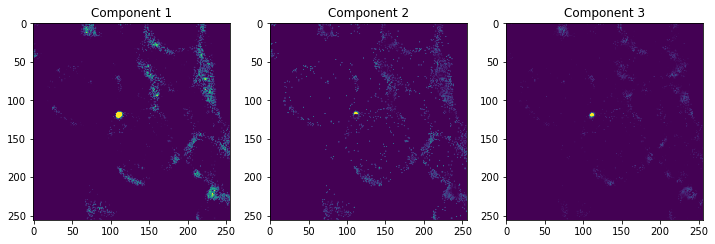

In [31]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
ax.imshow(tunmix[0],vmin=0,vmax=tunmix[0].max()/20)
plt.title('Component 1')
ax=plt.subplot(1,3,2)
ax.imshow(tunmix[1],vmin=0,vmax=tunmix[0].max()/20)
plt.title('Component 2')
ax=plt.subplot(1,3,3)
ax.imshow(tunmix[2],vmin=0,vmax=tunmix[0].max()/20)
plt.title('Component 3')
plt.show()

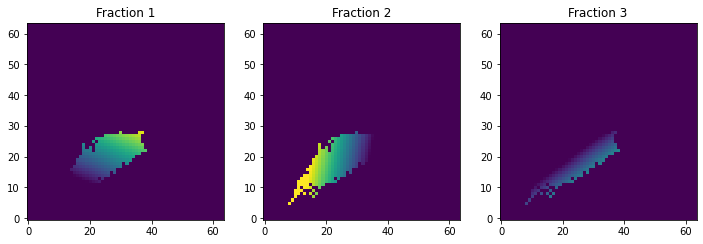

In [32]:
#show the 3 component fraction images
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
ax.imshow(tfrac[0],vmin=0,vmax=1)
ax.invert_yaxis()
plt.title('Fraction 1')
ax=plt.subplot(1,3,2)
ax.imshow(tfrac[1],vmin=0,vmax=1)
ax.invert_yaxis()
plt.title('Fraction 2')
ax=plt.subplot(1,3,3)
ax.imshow(tfrac[2],vmin=0,vmax=1)
ax.invert_yaxis()
plt.title('Fraction 3')
plt.show()

In [33]:
#finally try the simulation method to generate the fraction images
sfrac=flimtools.sim_fractions(refpos2)

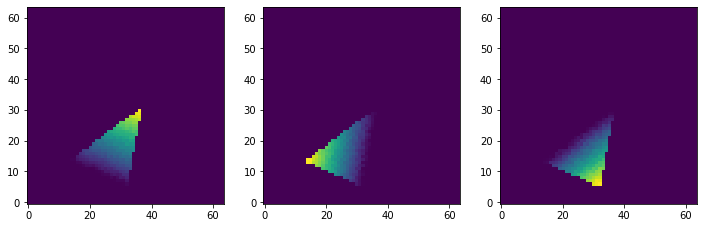

In [34]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
ax.imshow(sfrac[0])
ax.invert_yaxis()
ax=plt.subplot(1,3,2)
ax.imshow(sfrac[1])
ax.invert_yaxis()
ax=plt.subplot(1,3,3)
ax.imshow(sfrac[2])
ax.invert_yaxis()
plt.show()